In [1]:
using LinearAlgebra
import Plots as plt

include("../lib/test_functions.jl")
import .TestFunctions: michalewicz, ackley, wheeler

include("../lib/gif.jl")

plot_animation (generic function with 1 method)

In [2]:
f = michalewicz(10)
f = ackley()
# f, ∇f = wheeler(1.5)

plt.default(label=false, colorbar=false)
plotsize = (540, 540)

xdomain = LinRange(-5, 5, 400)
ydomain = LinRange(-5, 5, 400)

function plot_heatmap_and_population(population; size=plotsize)
    plot = plt.heatmap(xdomain, ydomain, (x, y) -> f([x, y]); color=plt.cgrad(:ice), xaxis=false, yaxis=false, size=size)
    population_size = Base.size(population)[1]
    if population_size > 0
        xs = [individual.x[1] for individual in population]
        ys = [individual.x[2] for individual in population] 
        plt.scatter!(
            plot,
            xs,
            ys,
            markershape=:circle,
            markersize=2.5,
            markerstrokewidth=0
        )
        plt.quiver!(
            plot,
            xs,
            ys,
            quiver=([individual.v[1] for individual in population], [individual.v[2] for individual in population]),
            color=:orange
        )
    end
    return plot
end

# plot_heatmap_and_population([])

plot_heatmap_and_population (generic function with 1 method)

"Optimum: x=[-0.0038, -0.002]"

  2.740875 seconds (6.42 M allocations: 343.792 MiB, 6.07% gc time, 99.87% compilation time)


┌ Info: Saved animation to 
│   fn = /tmp/jl_QlE30TifGZ.gif
└ @ Plots /home/nguymin4/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_QlE30TifGZ.gif")
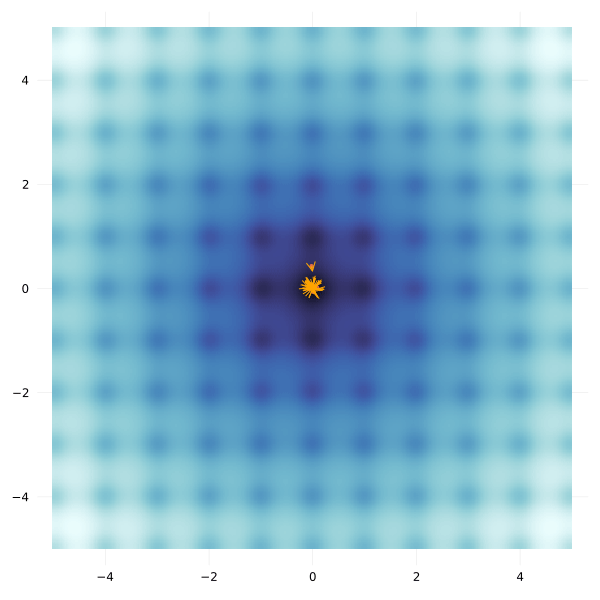

In [3]:
import Random
import Distributions

Random.seed!(0)

mutable struct Particle
    x::Vector{Float64}
    v::Vector{Float64}
    x_best::Vector{Float64}
end

function initialize_population(f, population_size::Int64)
    X = nothing
    for (lb, ub) in zip([xdomain[1], ydomain[1]], [xdomain[end], ydomain[end]])
        X_at_dim = rand(Distributions.Uniform(lb, ub), population_size)'
        X = X == nothing ? X_at_dim : vcat(X, X_at_dim)
    end
    V = rand(Float64, size(X))
    population = [Particle(x, v, x) for (x, v) in zip(eachcol(X), eachcol(V))]

    Y = mapslices(f, X, dims=1)[1,:]
    min_y_idx = argmin(Y)
    x_best, y_best = copy(X[:,min_y_idx]), Y[min_y_idx]
    return population, x_best, y_best, length(x_best)
end

function particle_swarm(f; w::Float64=1.0, c1::Float64=1.0, c2::Float64=1.0, population_size=20, max_iter=10)
    history = []
    population, x_best, y_best, n = initialize_population(f, population_size)
    push!(history, population)
    for _ in 1:max_iter
        for individual in population
            r1, r2 = rand(n), rand(n)
            individual.v = w * individual.v + c1 * r1 .* (individual.x_best - individual.x) + c2 * r2 .* (x_best - individual.x)
            individual.x += individual.v
            y = f(individual.x)
            if y < y_best
                x_best, y_best = copy(individual.x), y
            end
            if y < f(individual.x_best)
                individual.x_best = copy(individual.x)
            end
        end
        push!(history, deepcopy(population))
    end
    y = map(individual -> f(individual.x), population)
    return population[argmin(y)].x, history
end

x, history = @time particle_swarm(f; w=1e-2, c1=0.75, c2=0.75, population_size=25, max_iter=10)
display("Optimum: x=$(round.(x, digits=4))")
plot_animation(plot_heatmap_and_population, history)